In [23]:
dataset_name = "all_data_gift_certificates"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [24]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import math
import warnings
warnings.filterwarnings('ignore')

# Preprocess dataset

In [25]:
data = pd.read_csv(path, header=0)
data["timestamp"] = data["BeginTime"].values
del data["BeginTime"]
data["value"] = data["Count"].values
del data["Count"]
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '1H', data))

# write to csv for htm
# data.to_csv("/home/cfreeman/Desktop/prefill/" + dataset_name + ".csv", index=False)

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="1H", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2016-04-06 16:00:00",
                      "2016-07-25 19:00:00",
                      "2016-11-19 20:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2016-01-01 00:00:00
End date:  2016-12-31 23:00:00
Missing time stamps: 
 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
Length:  8784
Time step size:  1H
Start Date:  2016-01-01 00:00:00
End Date:  2016-12-31 23:00:00
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [2320, 4963, 7772]


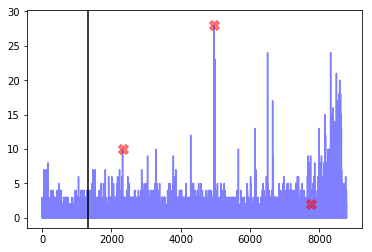

In [10]:
ad.plot_outliers([], true_outlier_indices)

# windowed gaussian

In [5]:
# optimization step
step_sizes = [100, 200, 300, 400, 500]

opt_dict = {}

for step_size in step_sizes:
    print("Step size: ", step_size)
    output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                       step_size = step_size, 
                                       optimize=True,
                                       plot_anomaly_score=False)
    print("MSE: ", output_dict["MSE"])
    opt_dict[step_size] = output_dict["MSE"]

best_step_size = min(opt_dict, key=opt_dict.get)
print("\nbest step size: ", best_step_size)

Step size:  100
MSE:  1.055017265180487
Step size:  200
MSE:  1.054679970053771
Step size:  300
MSE:  1.0545433035277587
Step size:  400
MSE:  1.0545433035277587
Step size:  500
MSE:  1.0545433035277587

best step size:  300


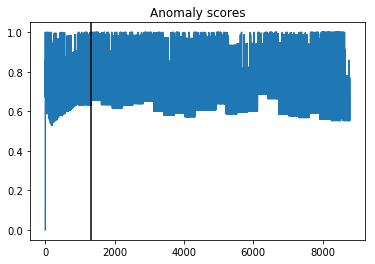

Time:  0.2317342758178711


['anomaly_scores/windowed_gaussian/all_data_gift_certificates']

In [6]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name

output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                   step_size = best_step_size, 
                                   plot_anomaly_score=True)

print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# SARIMA: using autoarima


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : 3524.748
 Regression with ARIMA(0,1,0) errors : 4323.997
 Regression with ARIMA(1,1,0) errors : 3961.767
 Regression with ARIMA(0,1,1) errors : 3524.549
 ARIMA(0,1,0)                    : 4321.894
 Regression with ARIMA(1,1,1) errors : Inf
 Regression with ARIMA(0,1,2) errors : 3524.08
 Regression with ARIMA(1,1,2) errors : Inf
 Regression with ARIMA(0,1,3) errors : 3523.357
 Regression with ARIMA(1,1,3) errors : Inf
 Regression with ARIMA(0,1,4) errors : 3524.878
 Regression with ARIMA(1,1,4) errors : Inf
 ARIMA(0,1,3)                    : 3521.353
 ARIMA(0,1,2)                    : 3521.269
 ARIMA(0,1,1)                    : 3522.368
 ARIMA(1,1,2)                    : Inf
 ARIMA(1,1,1)                    : Inf
 ARIMA(1,1,3)                    : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,2)                    : Inf
 ARIMA(0,1,3)                    : Inf

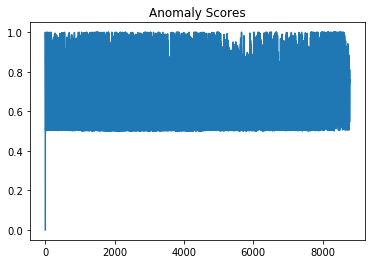

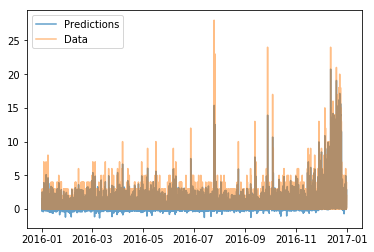

Time:  60.85162091255188


['anomaly_scores/SARIMA_auto/all_data_gift_certificates']

In [7]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, s=24, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

In [8]:
# optimization step

step_sizes = [100, 200, 300, 400, 500]
seasonality_prior_scales = [1, 5, 10, 15, 20]
seasonality_modes = ["additive", "multiplicative"]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for seasonality_prior_scale in seasonality_prior_scales:
        for seasonality_mode in seasonality_modes:
            for changepoint_prior_scale in changepoint_prior_scales:
                
                mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                          daily_seasonality=True, 
                                          seasonality_prior_scale=seasonality_prior_scale,
                                          seasonality_mode=seasonality_mode,
                                          changepoint_prior_scale=changepoint_prior_scale,
                                          step_size=step_size,
                                          optimize=True)
                print("Step Size: ", step_size)
                print("Seasonality Prior Scale: ", seasonality_prior_scale)
                print("Seasonality Mode: ", seasonality_mode)
                print("Changepoint Prior Scale: ", changepoint_prior_scale)
                print("MSE: ",mse)
                
                key_str = "Step Size " + str(step_size) + " Seasonality Prior Scale " + str(seasonality_prior_scale) +" Seasonality Mode " + str(seasonality_mode) +" Changepoint Prior Scale " + str(changepoint_prior_scale)
                
                opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7956883476076434


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.794668603825379


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7953317493709199


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949493180857735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.795190371081906


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7798730304325723


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.783106978250743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7810135019662298


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7806882728959622


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7808469072745695


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7956633628218385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7946946191393155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7951614279180846


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7950687675729522


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7951928965851872


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7792237619671074


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7834172256791798


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7809560568715066


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7805518468498234


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7807171548369682


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.795535297345211


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7947447643506016


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7950423276873506


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949928440756273


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7951917416150541


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7797477940298806


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7829772721245509


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.780851871313424


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7806697289661291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7809802920741892


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.795696178810579


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.794751924775255


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7950589316316283


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949318966922363


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7952377031805998


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7790909522353642


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.783245766929329


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7810586118928465


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7807029747519645


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7808796412202782


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7958002860945111


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7947788859654147


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7954395635107508


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7950295471956286


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7950925938400134


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7790822469888724


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7836673364589428


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7808251892082225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7805798198810744


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.780699299846123


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7956883476076434


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.794668603825379


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7953317493709199


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949493180857735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.795190371081906


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7798730304325723


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.783106978250743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7810135019662298


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7806882728959622


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7808469072745695


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7956633628218385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7946946191393155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7951614279180846


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7950687675729522


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7951928965851872


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7792237619671074


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7834172256791798


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7809560568715066


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7805518468498234


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7807171548369682


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.795535297345211


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7947447643506016


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7950423276873506


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949928440756273


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7951917416150541


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7797477940298806


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7829772721245509


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.780851871313424


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7806697289661291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7809802920741892


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.795696178810579


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.794751924775255


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7950589316316283


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949318966922363


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7952377031805998


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7790909522353642


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.783245766929329


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7810586118928465


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7807029747519645


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7808796412202782


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7958002860945111


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7947788859654147


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7954395635107508


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7950295471956286


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7950925938400134


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7790822469888724


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7836673364589428


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7808251892082225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7805798198810744


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.780699299846123


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7956883476076434


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.794668603825379


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7953317493709199


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949493180857735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.795190371081906


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7798730304325723


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.783106978250743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7810135019662298


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7806882728959622


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7808469072745695


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7956633628218385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7946946191393155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7951614279180846


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7950687675729522


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7951928965851872


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7792237619671074


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7834172256791798


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7809560568715066


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7805518468498234


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7807171548369682


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.795535297345211


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7947447643506016


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7950423276873506


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949928440756273


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7951917416150541


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7797477940298806


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7829772721245509


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.780851871313424


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7806697289661291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7809802920741892


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.795696178810579


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.794751924775255


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7950589316316283


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949318966922363


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7952377031805998


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7790909522353642


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.783245766929329


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7810586118928465


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7807029747519645


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7808796412202782


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7958002860945111


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7947788859654147


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7954395635107508


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7950295471956286


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7950925938400134


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7790822469888724


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7836673364589428


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7808251892082225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7805798198810744


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.780699299846123


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7956883476076434


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.794668603825379


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7953317493709199


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949493180857735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.795190371081906


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7798730304325723


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.783106978250743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7810135019662298


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7806882728959622


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7808469072745695


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7956633628218385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7946946191393155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7951614279180846


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7950687675729522


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7951928965851872


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7792237619671074


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7834172256791798


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7809560568715066


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7805518468498234


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7807171548369682


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.795535297345211


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7947447643506016


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7950423276873506


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949928440756273


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7951917416150541


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7797477940298806


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7829772721245509


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.780851871313424


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7806697289661291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7809802920741892


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.795696178810579


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.794751924775255


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7950589316316283


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949318966922363


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7952377031805998


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7790909522353642


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.783245766929329


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7810586118928465


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7807029747519645


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7808796412202782


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7958002860945111


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7947788859654147


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7954395635107508


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7950295471956286


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7950925938400134


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7790822469888724


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7836673364589428


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7808251892082225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7805798198810744


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.780699299846123


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7956883476076434


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.794668603825379


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7953317493709199


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949493180857735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.795190371081906


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7798730304325723


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.783106978250743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7810135019662298


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7806882728959622


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7808469072745695


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7956633628218385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7946946191393155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7951614279180846


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7950687675729522


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7951928965851872


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7792237619671074


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7834172256791798


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7809560568715066


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7805518468498234


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7807171548369682


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.795535297345211


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7947447643506016


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7950423276873506


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949928440756273


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7951917416150541


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7797477940298806


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7829772721245509


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.780851871313424


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7806697289661291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7809802920741892


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.795696178810579


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.794751924775255


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7950589316316283


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7949318966922363


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7952377031805998


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7790909522353642


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.783245766929329


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7810586118928465


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7807029747519645


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.7808796412202782


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.7958002860945111


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.7947788859654147


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.7954395635107508


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.7950295471956286


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.7950925938400134


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.7790822469888724


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.7836673364589428


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.7808251892082225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.7805798198810744
Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.780699299846123

best params:  Step Size 100 Seasonality Prior Scale 20 Seasonality Mode multiplicative Changepoint Prior Scale 0.01


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


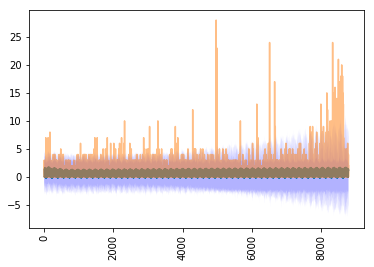

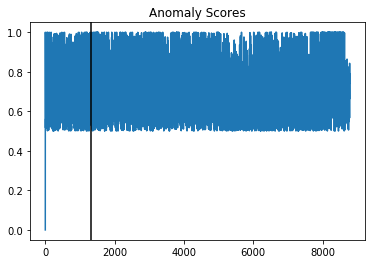

Time:  17.18219232559204


['anomaly_scores/Prophet/all_data_gift_certificates']

In [9]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  daily_seasonality=True, 
                                  seasonality_prior_scale=20,
                                  seasonality_mode="multiplicative",
                                  changepoint_prior_scale=.01,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# STL Resid

In [10]:
# optimization step
swindows = ["periodic", 5,7,9,11]
sdegrees = [0,1,2]
twindows = [5,7,9,11]
tdegrees = [0,1,2]
inners = [1,2,3]
outers = [0,1]
opt_dict = {}

for swindow in swindows:
    for sdegree in sdegrees:
        for twindow in twindows:
            for tdegree in tdegrees:
                for inner in inners:
                    for outer in outers:
                        
                        print("swindow: ", swindow)
                        print("sdegree: ", sdegree)
                        print("twindow: ", twindow)
                        print("tdegree: ", tdegree)
                        print("inner: ", inner)
                        print("outer: ", outer)
                        
                        
                        try:
  
                            stl_resid_sum = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=swindow, 
                                                         sdegree=sdegree, twindow=twindow, tdegree=tdegree, inner=inner, 
                                                         outer=outer, fill_option="linear", optimize=True)


                            print("STL Resid Sum: ",stl_resid_sum)

                            key_str = "swindow " + str(swindow) + " sdegree " + str(sdegree) +" twindow " + str(twindow) +" tdegree " + str(tdegree) +" inner " + str(inner) +" outer " + str(outer)

                            opt_dict[key_str] = stl_resid_sum

                        except:
                            print("Fail")
                            continue

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  483.0077972576691
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  483.0192113685593
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  482.9955627739947
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  483.0077972576691
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  482.99034417594714
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  483.00037789245704
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  1
inner: 

R stlplus completed: 1317 no missing True
STL Resid Sum:  540.7563037834435
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  540.7643981647486
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  793.1732687171126
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  793.1773285544218
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  793.1702323928441
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  793.1732687171126
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  7

R stlplus completed: 1317 no missing True
STL Resid Sum:  414.3299871290367
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  414.3257219712867
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  414.3279057433415
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  737.3439374218165
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  737.3534520802851
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  737.3376412517197
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  737.34

R stlplus completed: 1317 no missing True
STL Resid Sum:  0.18318944859361766
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  0.1889568431295291
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  0.17759808811491207
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  0.18605079924818657
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  645.2884129439452
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  645.3075682223433
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum: 

R stlplus completed: 1317 no missing True
STL Resid Sum:  641.4246498157001
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  641.3970057747885
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  641.409112215206
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  641.3887418777592
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  641.402297692974
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  233.37053602502115
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  231.6424885332972

R stlplus completed: 1317 no missing True
STL Resid Sum:  263.22816630186173
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  262.42616252371664
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  263.3056663789754
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  263.0957993024869
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  372.75984979189184
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  372.12652135270395
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  373.45235094295316
swindow:  5
sdegree:  

R stlplus completed: 1317 no missing True
STL Resid Sum:  190.14736448230715
swindow:  5
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  191.33011223880646
swindow:  5
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  191.18563595128737
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  336.37251605548965
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  335.6527103146389
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  337.2303516434851
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  336.37251605548965
swindow:  5
sdegree:  1
t

R stlplus completed: 1317 no missing True
STL Resid Sum:  0.0006720302442669156
swindow:  5
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  0.003713839457234537
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  8.142874462364974
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  8.039123851960285
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  8.254412408615607
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  8.142874462364974
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  8.253765787948682
swindow:  5
sdegree:  2

R stlplus completed: 1317 no missing True
STL Resid Sum:  8.174410122835756
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  324.17162918568795
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  323.7351340053494
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  325.41843365393584
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  324.17162918568795
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  325.59616185049606
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  325.15766536285236
swindow:  7
sdegree:  0
t

R stlplus completed: 1317 no missing True
STL Resid Sum:  521.9465136846445
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  520.7108564361602
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  522.5404459260915
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  521.9465136846445
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  522.5976070127685
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  522.4192702978992
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  511.1999227064218
swindow:  7
sdegree:  0


R stlplus completed: 1317 no missing True
STL Resid Sum:  476.56085382327296
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  478.56481505740186
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  477.88141087440556
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  478.6529218829649
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  478.41512042756915
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  477.76992856388944
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  476.41215913331723
swindow:  7
sdegree:  1


R stlplus completed: 1317 no missing True
STL Resid Sum:  248.32475549883674
swindow:  7
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  247.29758641595706
swindow:  7
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  248.43600141293732
swindow:  7
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  248.14449430724287
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  247.27055089192731
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  246.0103580385728
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  248.30527678051303
swindow:  7
sdegree:  2


R stlplus completed: 1317 no missing True
STL Resid Sum:  372.3354804215066
swindow:  9
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  373.5118289919836
swindow:  9
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  373.14994364012597
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  370.8740198240016
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  370.24784182330376
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  371.9543519489457
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  370.8740198240016
swindow:  9
sdegree:  0
twin

R stlplus completed: 1317 no missing True
STL Resid Sum:  600.0761622795233
swindow:  9
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  599.9522256647675
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  587.163145162321
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  585.4831047803232
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  587.6985407846287
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  587.163145162321
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  587.7428905792556
swindow:  9
sdegree:  0
tw

R stlplus completed: 1317 no missing True
STL Resid Sum:  543.2296686954521
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  542.646775493568
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  541.612279805943
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  543.3128086363851
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  542.646775493568
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  543.3895570053103
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  543.1654340187779
swindow:  9
sdegree:  1
twindow: 

R stlplus completed: 1317 no missing True
STL Resid Sum:  365.69704986512414
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  364.78414676508686
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  366.4082490621569
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  365.69704986512414
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  366.4934783534758
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  366.2698778245549
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  231.3524936956346
swindow:  9
sdegree:  2
twi

R stlplus completed: 1317 no missing True
STL Resid Sum:  397.7815410564744
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  399.1744876278307
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  398.3377680007959
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  399.2626040400666
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  399.0038098688833
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  0.2205742205579562
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  0.29057471102672766
swindow:  11
sdegree:

R stlplus completed: 1317 no missing True
STL Resid Sum:  630.7156968559119
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  630.3202166001631
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  630.7463522580613
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  630.6496290091559
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  526.2582835066083
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  525.580304606093
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  526.6423633820572
swindow:  11
sdegre

R stlplus completed: 1317 no missing True
STL Resid Sum:  569.4636590899853
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  570.1114567829127
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  569.9523211096852
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  420.1726272337671
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  419.6953544741827
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  420.67296887422805
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  420.1726272337671
swindow:  11
sdegree:  

R stlplus completed: 1317 no missing True
STL Resid Sum:  425.58349586583375
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  425.3851671160421
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  273.13521483133263
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  274.5434941032464
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  273.5936600798412
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  1
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  273.13521483133263
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  0
1317
R stlplus completed: 1317 no missing True
STL Resid Sum:  273.6923646096661
swindow:  11
sdegree:

In [11]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24,
                           swindow=5, 
                           sdegree=2, 
                           twindow=5, 
                           tdegree=2, 
                           inner=3, 
                           outer=0, 
                           fill_option="linear", optimize=False)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

8784
R stlplus completed: 8784 no missing True
Time:  1.3949832916259766


['anomaly_scores/stl/all_data_gift_certificates']

# Anomalous

In [12]:
# only need for one window size
# save_path = "anomaly_scores/anomalous/" + dataset_name
# output_dict = ad.anomalous(ts_length=100,
#                            upper=(.2/100) * ad.get_length(),
#                            plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# Twitter AD

In [13]:
# only need for one window size
# save_path = "anomaly_scores/Twitter/" + dataset_name
# output_dict = ad.twitterad(period=24, max_anoms=((.2/100) * ad.get_length())/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# HTM

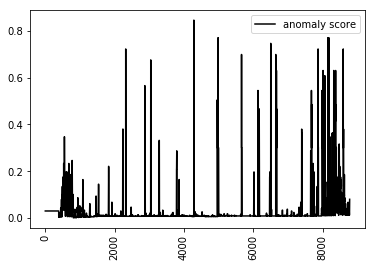

Time:  81.25


['anomaly_scores/HTM/all_data_gift_certificates']

In [14]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", "81.25")
output_dict = {"Anomaly Scores": anomaly_scores, "Time": "81.25"}
joblib.dump(output_dict, save_path)

# HOTSAX

In [15]:
# only need for one window size
# save_path = "anomaly_scores/hotsax/" + dataset_name
# output_dict = ad.hotsax(win_size=50, num_discords=int((.2/100) * ad.get_length()),
#                a_size=3, paa_size=3, z_threshold=0.01,
#                plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

In [16]:
print(output_dict["Time"])

81.25


# GLM

In [26]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='poisson', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

 27%|██▋       | 2356/8784 [00:00<00:00, 23551.43it/s]

Initial Mean 0.6484434320425209
Initial StdDev 1.0241125259621566


 27%|██▋       | 2408/8784 [00:00<00:00, 24074.74it/s]

eta:  0.5
lambda:  0.99
MSE:  inf
Initial Mean 0.6484434320425209
Initial StdDev 1.0241125259621566


 27%|██▋       | 2356/8784 [00:00<00:00, 23549.24it/s]

eta:  0.5
lambda:  0.999
MSE:  2.7856232276193893
Initial Mean 0.6484434320425209
Initial StdDev 1.0241125259621566


 25%|██▌       | 2212/8784 [00:00<00:00, 22110.69it/s]

eta:  0.5
lambda:  0.9999
MSE:  3.1452905023616577
Initial Mean 0.6484434320425209
Initial StdDev 1.0241125259621566


 26%|██▌       | 2260/8784 [00:00<00:00, 22590.27it/s]

eta:  1
lambda:  0.99
MSE:  inf
Initial Mean 0.6484434320425209
Initial StdDev 1.0241125259621566


 26%|██▌       | 2297/8784 [00:00<00:00, 22965.31it/s]

eta:  1
lambda:  0.999
MSE:  3.633743698248979
Initial Mean 0.6484434320425209
Initial StdDev 1.0241125259621566


100%|██████████| 8784/8784 [00:00<00:00, 22874.47it/s]


eta:  1
lambda:  0.9999
MSE:  4.005786068835583

best params:  eta 0.5 lambda 0.999


 27%|██▋       | 2337/8784 [00:00<00:00, 23360.78it/s]

Initial Mean 0.6484434320425209
Initial StdDev 1.0241125259621566


100%|██████████| 8784/8784 [00:00<00:00, 22877.89it/s]


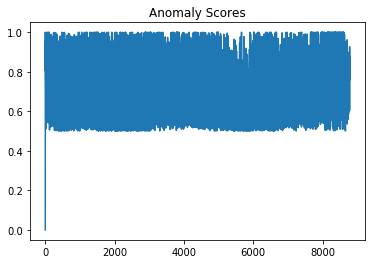

Time:  1.5138001441955566


['anomaly_scores/GLM/all_data_gift_certificates']

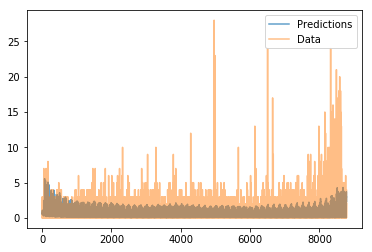

In [27]:
save_path = "anomaly_scores/GLM/" + dataset_name
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='poisson', 
                     eta=.5,
                     lambda_=.999,
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)